In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 18})


# data summary

In [67]:
comment_data = pd.read_csv('../data/train.csv.zip', 
                           header=0, 
                           compression='zip')

In [70]:
comment_data.loc[:,'toxic':'identity_hate']

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


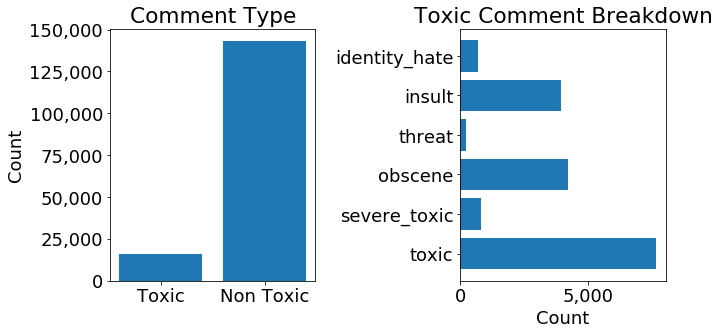

In [76]:
fig, ax = plt.subplots(1,2)

#c = np.sum(comment_data.loc[:,'toxic':'identity_hate'].any(axis=1))
counts = {
    'Toxic' : 16225,
    'Non Toxic' : 143346
}

ax[0].bar(counts.keys(), counts.values())
ax[0].set_yticklabels(['{:,}'.format(int(x)) for x in ax[0].get_yticks().tolist()])
ax[0].set_ylabel("Count")
ax[0].set_title("Comment Type")


tox_counts = comment_data.loc[:,'toxic':'identity_hate'].sum().to_dict()

ax[1].barh(list(tox_counts.keys()), tox_counts.values())
ax[1].set_xticklabels(['{:,}'.format(int(x)) for x in ax[1].get_xticks().tolist()])
ax[1].set_xlabel("Count")
ax[1].set_title("Toxic Comment Breakdown")

fig.tight_layout()

## word counts

In [71]:
word_counts = pd.read_csv('../word_lists/all_words_ascii_noquote_nodigit_destem.tsv', sep='\t', header=None)
word_counts.columns = ['word', 'counts']

In [72]:
word_counts

,word,counts
0,shirvington,1
1,aircracft,1
2,yvesnimmo,1
3,voydan,1
4,mitsurugi,1
...,...,...
142270,you,218200
142271,and,224236
142272,of,225062
142273,to,297516


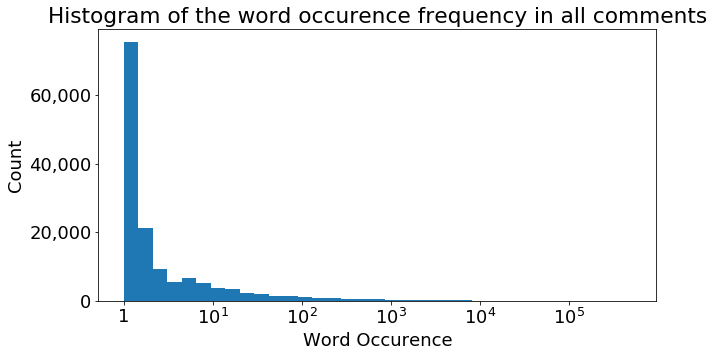

In [79]:
fig, ax = plt.subplots()
plt.hist(np.log10(word_counts.counts), bins=35)
plt.title('Histogram of the word occurence frequency in all comments')
plt.xlabel('Word Occurence')
plt.ylabel('Count')
ax.set_xticklabels(['','1','$10^1$','$10^2$','$10^3$','$10^4$','$10^5$']);
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
#ax.set_yscale('log')

# Important Words

In [90]:
imp_tox = pd.read_csv('../importances/new/importance_scores_toxic.tsv',header=None,sep='\t')
imp_tox.columns = ['TYPE', 'WORD', 'IMPORTANCE']

,TYPE,WORD,IMPORTANCE
0,non_toxic,articl,1.452051e-04
1,non_toxic,page,4.551806e-05
2,non_toxic,the,7.322959e-06
3,non_toxic,edit,2.619355e-05
4,non_toxic,wikipedia,3.725451e-06
...,...,...,...
19995,toxic,roam,1.010938e-07
19996,toxic,grill,2.923971e-07
19997,toxic,congo,-4.382901e-09
19998,toxic,bland,8.358130e-08


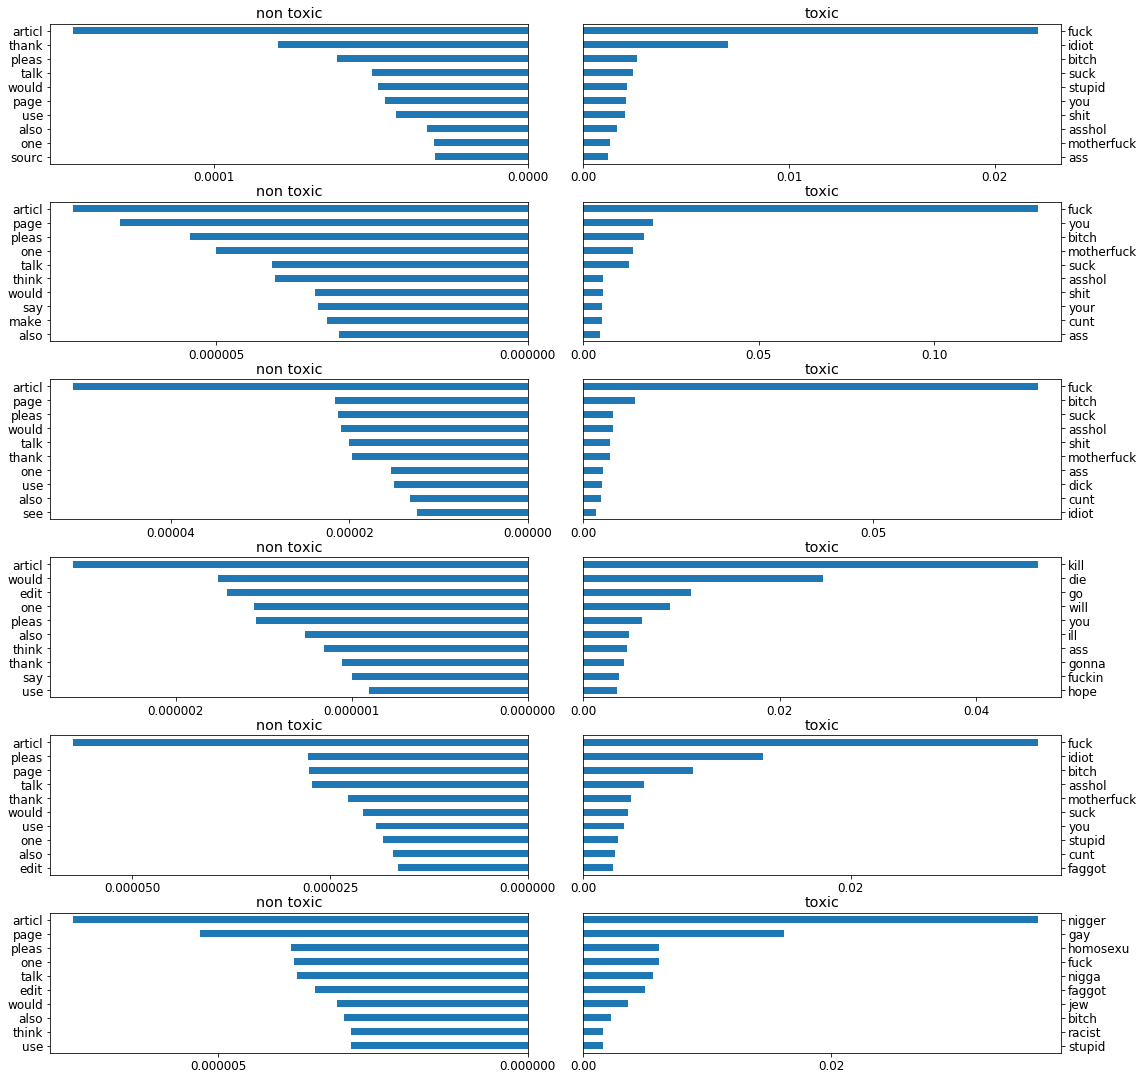

In [150]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(nrows=6, ncols=2, sharey=False)
fig.tight_layout()

for i, category in enumerate(["toxic","severe_toxic","obscene","threat","insult","identity_hate"]):
    # READ IN FILE
    file_name = "../importances/new/importance_scores_" + category + ".tsv"
    imp_tox = pd.read_csv(file_name, header=None, sep='\t')
    imp_tox.columns = ['TYPE', 'WORD', 'IMPORTANCE']
    non_toxic = "non_" + category
    toxic = category
    
    # CREATE BAR PLOTS
    imp_tox[imp_tox.TYPE==non_toxic]\
                .sort_values(by=['IMPORTANCE'],ascending=False)[:10]\
                .sort_values(by=['IMPORTANCE'],ascending=True)\
                .plot.barh(x='WORD', y='IMPORTANCE',ax=axs[i,0])
    axs[i,0].invert_xaxis()
    axs[i,0].set_ylabel('')
    axs[i,0].set_title('non toxic')
    axs[i,0].legend().set_visible(False)
    axs[i,0].locator_params(axis='x', nbins=3)
    imp_tox[imp_tox.TYPE==toxic]\
                .sort_values(by=['IMPORTANCE'],ascending=False)[:10]\
                .sort_values(by=['IMPORTANCE'],ascending=True)\
                .plot.barh(x='WORD', y='IMPORTANCE',ax=axs[i,1])
    axs[i,1].yaxis.set_label_position("right")
    axs[i,1].yaxis.tick_right()
    axs[i,1].set_ylabel('')
    axs[i,1].set_title('toxic')
    axs[i,1].legend().set_visible(False)
    axs[i,1].locator_params(axis='x', nbins=3)


In [153]:
'''
top_idx = imp_tox[2].abs().argsort(1)[::-1][:20]
words0 = imp_tox.loc[imp_tox[0]=='non_toxic',:].sort_values(by=[2],ascending=False)[:10][1]
words1 = imp_tox.loc[imp_tox[0]=='toxic',:].sort_values(by=[2],ascending=False)[:10][1]
#words = list(set(words0.values) | set(words0.values))
words = [*words0.values, *words1.values]
imp_tox[imp_tox[1].isin(words)]
''';

# ROC curve data

In [95]:
# training
roc_train = pd.read_csv('roc_train.tsv', header=0, sep='\t')
roc_train['sensitivity'] = roc_train.TP / (roc_train.TP + roc_train.FN)
roc_train['specificity'] = roc_train.TN / (roc_train.TN + roc_train.FP)
# validation
roc_valid = pd.read_csv('roc_valid.tsv', header=0, sep='\t')
roc_valid['sensitivity'] = roc_valid.TP / (roc_valid.TP + roc_valid.FN)
roc_valid['specificity'] = roc_valid.TN / (roc_valid.TN + roc_valid.FP)
# testing
roc_test = pd.read_csv('roc_test.tsv', header=0, sep='\t')
roc_test['sensitivity'] = roc_test.TP / (roc_test.TP + roc_test.FN)
roc_test['specificity'] = roc_test.TN / (roc_test.TN + roc_test.FP)
roc_test

,TN,FP,FN,TP,sensitivity,specificity
0,369370,0,14498,0,0.000000,1.000000
1,369370,0,14498,0,0.000000,1.000000
2,369370,0,14495,3,0.000207,1.000000
3,369367,3,14476,22,0.001517,0.999992
4,369330,40,14347,151,0.010415,0.999892
...,...,...,...,...,...,...
995,278272,91098,699,13799,0.951786,0.753369
996,283722,85648,726,13772,0.949924,0.768124
997,276752,92618,551,13947,0.961995,0.749254
998,277470,91900,578,13920,0.960132,0.751198


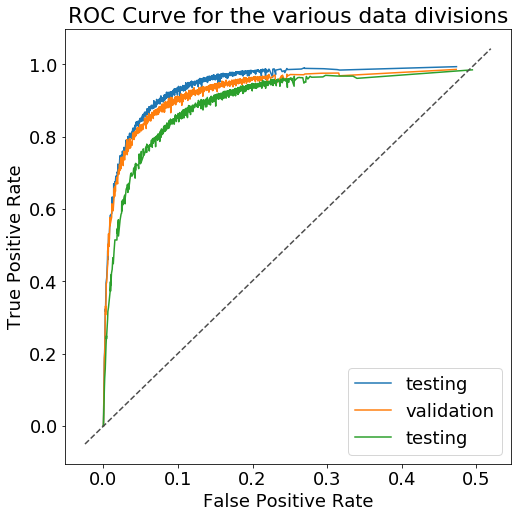

In [5]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
roc_train = roc_train.sort_values(by=['specificity', 'sensitivity'])
roc_valid = roc_valid.sort_values(by=['specificity', 'sensitivity'])
roc_test = roc_test.sort_values(by=['specificity', 'sensitivity'])
ax.plot(1-roc_train['specificity'], roc_train['sensitivity'], label='testing')
ax.plot(1-roc_valid['specificity'], roc_valid['sensitivity'], label='validation')
ax.plot(1-roc_test['specificity'], roc_test['sensitivity'], label='testing')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("ROC Curve for the various data divisions")
ax.legend();